In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 8*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-13 15:53:21.398926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 15:53:21.585774: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-13 15:53:22.321324: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

In [116]:
sim_name = "Koch_Meinhardt_5"
x_slice=slice(0,100,1)#slice(30,65,1)#slice(0,100,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,100,1)#slice(50,85,1)#slice(0,100,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-4,
               data_time_len=3,
               data_time_step=1)

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]

In [162]:
import copy

class NN_test(tf.Module):
    def __init__(self, dtype=tf.float32, **kwargs):        
        super().__init__(**kwargs)
        self.dtype = dtype
        self.__version__ = 0.1
        self.layers = [3, 8, 8, 2]
        self.num_layers = len(self.layers)
        self.build()
    def __make_variables__(self, k, initializer):
        return tf.Variable(initializer(shape=k, dtype=self.dtype))

    def build(self):
        self.weights = []
        self.scales = []
        self.biases = []

        for i in range(0, self.num_layers - 1):
            input_n, output_n = self.layers[i], self.layers[i + 1]
            rnd_init = tf.random_normal_initializer(stddev=tf.sqrt(6.0 / (input_n + output_n)))
            W = tf.Variable(
                self.__make_variables__([input_n, output_n], rnd_init),
                dtype=self.dtype,
                name=f"W1_{i+1}",
            )
            a = tf.Variable(
                tf.ones([1, output_n], dtype=self.dtype),
                dtype=self.dtype,
                name=f"a1_{i+1}",
            )
            b = tf.Variable(
                tf.zeros([1, output_n], dtype=self.dtype),
                dtype=self.dtype,
                name=f"b1_{i+1}",
            )
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
            
    def act(self, x):
        return tf.tanh(x)
    
    #@tf.function        
    def net(self, H):
        #print(H.shape)    
        #print(H)
        for i, (W, a, b) in enumerate(zip(self.weights, self.scales, self.biases)):            
            #print(W.shape)
            #print(W)
            mul_outputs = tf.matmul(H, W)
            outputs = a * mul_outputs + b            
            H = self.act(outputs)        

        return outputs

    def copy(self):
        return copy.deepcopy(self)

In [163]:
nn = NN_test()

In [164]:
print([ w.shape for w in nn.weights])
print([ w.shape for w in nn.biases])
print([ w.shape for w in nn.scales])

[TensorShape([3, 8]), TensorShape([8, 8]), TensorShape([8, 2])]
[TensorShape([1, 8]), TensorShape([1, 8]), TensorShape([1, 2])]
[TensorShape([1, 8]), TensorShape([1, 8]), TensorShape([1, 2])]


In [124]:
ts

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([637., 638., 639.], dtype=float32)>

In [117]:
x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)
# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)
X, Y = tf.meshgrid(x, y)
ts = tf.constant(pattern.t_star, dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
H = tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )

In [123]:
H.shape

TensorShape([3, 100, 100, 3])

In [167]:
def gen_series():    
    for i in range(H.shape[0]):
        h = H[i, :, :, :]
        yield h, pattern.c[..., i]    
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=(H.shape[1:], pattern.c.shape[:-1]))

In [168]:
inputs = tf.constant([])
nn.net(H)

<tf.Tensor: shape=(2, 5, 5, 2), dtype=float32, numpy=
array([[[[-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253]],

        [[-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253]],

        [[-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253]],

        [[-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253]],

        [[-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253],
         [-1.166625 , -2.1745253]]],


       [[[-1.166625 , -2.1745253],
         [-1.166625 , -2

In [14]:
optimizer=keras.optimizers.Adam(learning_rate=1e-2)
D_u = tf.constant(pattern.params["D_u"], nn.dtype, name="D_u")
D_v = tf.constant(pattern.params["D_v"], nn.dtype, name="D_v")
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 1e-4, 1e10,)

init_per = 1.0
sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                      nn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                      nn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                   nn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                    nn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                    nn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                      nn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf = (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)

#@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = elements[0]
        tape.watch(H)
        trainables = nn.trainable_variables

        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)
            
            outputs = nn.net(H)            
            ug = tf.squeeze(outputs[:, :, :, 0])
            vg = tf.squeeze(outputs[:, :, :, 1])
            
            grad_u = tape2.gradient(ug, H)
            u_x = grad_u[:, :, :, 0]
            u_y = grad_u[:, :, :, 1]
            u_t = grad_u[:, :, :, 2]
            
            grad_v = tape2.gradient(vg, H)
            v_x = grad_v[:, :, :, 0]
            v_y = grad_v[:, :, :, 1]
            v_t = grad_v[:, :, :, 2]
                    
        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, :, :, 0]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, H)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, :, :, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, :, :, 0]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, H)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, :, :, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                             
        u = elements[1][:, 0, :, :]
        v = elements[1][:, 1, :, :]
        
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
#         u_diff = u - elements[1][:, 0, :, :]
#         v_diff = v - elements[1][:, 1, :, :]
#         l2_u_obs = tf.reduce_sum(u_diff**2)
#         l2_v_obs = tf.reduce_sum(v_diff**2)

                
        #l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v
        l2 = l2_res_u + l2_res_v
        
    #print(trainables)  
    grads = tape.gradient(l2, trainables)

    print("=================================")
    print(list(grads))
    print()
    optimizer.apply_gradients(zip(grads, trainables))
    #return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)
    return (l2_res_u, l2_res_v)

NameError: name 'nn' is not defined

In [171]:
batch_size = 2
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f"  u: {losses[0]},  v: {losses[1]},\n"
           # f" Res u: {losses[1]}, Res v: {losses[2]},\n"
           )
    
losses = tu.train(epochs=5+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 2,
                  print_interval=1,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback,
                  epoch_callback=None)



Start of epoch 0
[<tf.Tensor: shape=(1, 8), dtype=float32, numpy=array([[-0., -0., -0., -0., -0.,  0., -0.,  0.]], dtype=float32)>, <tf.Tensor: shape=(1, 8), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>, None, <tf.Tensor: shape=(1, 8), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(1, 8), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>, <tf.Tensor: shape=(3, 8), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(8, 8), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0.,

at epoch 4
 total loss: 32.00284829013981  u: 0.0010248648468405008,  v: 32.00182342529297,

Time taken: 0.19s

Start of epoch 5
[<tf.Tensor: shape=(1, 8), dtype=float32, numpy=array([[-0., -0., -0., -0., -0.,  0., -0.,  0.]], dtype=float32)>, <tf.Tensor: shape=(1, 8), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>, None, <tf.Tensor: shape=(1, 8), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(1, 8), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>, <tf.Tensor: shape=(3, 8), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(8, 8), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [ ]:
0.0010248648468405008,  v: 32.00182342529297

In [6]:
def grads(pinn, inputs):
    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            u = tf.squeeze(outputs[:, 0])
            v = tf.squeeze(outputs[:, 1])
            
            grad_u = tape2.gradient(u, inputs)
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]
            u_t = grad_u[:, 2]
            
            grad_v = tape2.gradient(v, inputs)
            v_x = grad_v[:, 0]
            v_y = grad_v[:, 1]
            v_t = grad_v[:, 2]
                    
        grad_u_x = tape.gradient(u_x, inputs)
        u_xx = grad_u_x[:, 0]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, inputs)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, inputs)
        v_xx = grad_v_x[:, 0]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, inputs)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                                     
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_t))

In [118]:
class NN2(tu.NN):
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.scales = []
        self.biases = []
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[self.layers[i], self.layers[i + 1]])
            a = tf.Variable(tf.ones([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
        
        
    @tf.function
    def net(self, inputs):
        # Map the inputs to the range [-1, 1]
        H = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
        for W, a ,b in zip(self.weights[:-1], self.scales[:-1], self.biases[:-1]):
            outputs = tf.matmul(H, W)
            H = tf.tanh(a*outputs + b)

        W = self.weights[-1]
        a = self.scales[-1]
        b = self.biases[-1]
        outputs = tf.matmul(H, W)
        outputs = a*outputs + b*b/2.0
        return outputs

In [119]:
lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
pinn = NN2([3, 128, 128, 2], lb, ub, tf.float32)

In [120]:
optimizer=keras.optimizers.Adam(learning_rate=1e-2)

D_u = tf.constant(pattern.params["D_u"], pinn.dtype, name="D_u")
D_v = tf.constant(pattern.params["D_v"], pinn.dtype, name="D_v")
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 1e-4, 1e10,)

init_per = 1.0
sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                      pinn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                      pinn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                   pinn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                    pinn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                    pinn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                      pinn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf = (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)


@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = elements[0]
        tape.watch(H)
        trainables = pinn.trainable_variables

        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)
            
            outputs = pinn.net(H)
            ug = tf.squeeze(outputs[:, 0])
            vg = tf.squeeze(outputs[:, 1])
            
            grad_u = tape2.gradient(ug, H)
            u_x = grad_u[:, 1]
            u_y = grad_u[:, 0]
            u_t = grad_u[:, 2]
            
            grad_v = tape2.gradient(vg, H)
            v_x = grad_v[:, 1]
            v_y = grad_v[:, 0]
            v_t = grad_v[:, 2]
                    
        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, 1]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, H)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, 0]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, 1]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, H)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, 0]
        #v_ty = grad_v_y[:, :, :, 2]
                             
        u = tf.squeeze(elements[1][:, 0])
        v = tf.squeeze(elements[1][:, 1])
        #print(u)
        #print(u_xx)
        f = u * u * v / (1.0 + kappa_u * u * u)
        #print(u_xx.shape)
        #print(f.shape)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
#         u_diff = u - elements[1][:, 0, :, :]
#         v_diff = v - elements[1][:, 1, :, :]
#         l2_u_obs = tf.reduce_sum(u_diff**2)
#         l2_v_obs = tf.reduce_sum(v_diff**2)

                
        #l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v
        l2 = l2_res_u + l2_res_v
        
    #print(trainables)  
    grads = tape.gradient(l2, trainables)

#     print("=================================")
#     print(list(grads))
#     print()
    optimizer.apply_gradients(zip(grads, trainables))
    #return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)
    return (l2_res_u, l2_res_v)

In [122]:
H.shape

TensorShape([3, 100, 100, 3])

In [125]:
data = tf.reshape(H, (H.shape[0]*H.shape[1]*H.shape[2],3))
#pinn.net(data)

In [126]:
data.shape

TensorShape([30000, 3])

In [127]:
pattern.c.reshape(2, pattern.c.shape[1]*pattern.c.shape[2]*pattern.c.shape[3]).T.shape

(30000, 2)

In [128]:
c = pattern.c.reshape(2, pattern.c.shape[1]*pattern.c.shape[2]*pattern.c.shape[3]).T
def gen_series():    
    
    for i in range(data.shape[0]):
        h = data[i,:]
        yield h, c[i,:]    
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((3,),(2,)))

In [129]:
batch_size = 10000
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f"  u: {losses[0]},  v: {losses[1]},\n"
           # f" Res u: {losses[1]}, Res v: {losses[2]},\n"
           )
    
losses = tu.train(epochs=5000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 2,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=10,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 330666.0788116455  u: 930.4958038330078,  v: 329735.5830078125,

Time taken: 38.05s

Start of epoch 100
at epoch 100
 total loss: 195098.71478128433  u: 174.20993661880493,  v: 194924.50484466553,

Time taken: 8.82s

Start of epoch 200
at epoch 200
 total loss: 195077.25229167938  u: 163.05356121063232,  v: 194914.19873046875,

Time taken: 8.77s

Start of epoch 300
at epoch 300
 total loss: 195071.24696183205  u: 161.0348494052887,  v: 194910.21211242676,

Time taken: 8.76s

Start of epoch 400
at epoch 400
 total loss: 195261.52461910248  u: 160.96591091156006,  v: 195100.55870819092,

Time taken: 8.76s

Start of epoch 500
at epoch 500
 total loss: 195317.4720606804  u: 164.0033106803894,  v: 195153.46875,

Time taken: 8.76s

Start of epoch 600
at epoch 600
 total loss: 195101.16490459442  u: 162.69929790496826,  v: 194938.46560668945,

Time taken: 8.80s

Start of epoch 700
at epoch 700
 total loss: 195145.905513525  u: 161.0110204219818,  v: 1

In [130]:
(u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t) = grads(pinn, data)

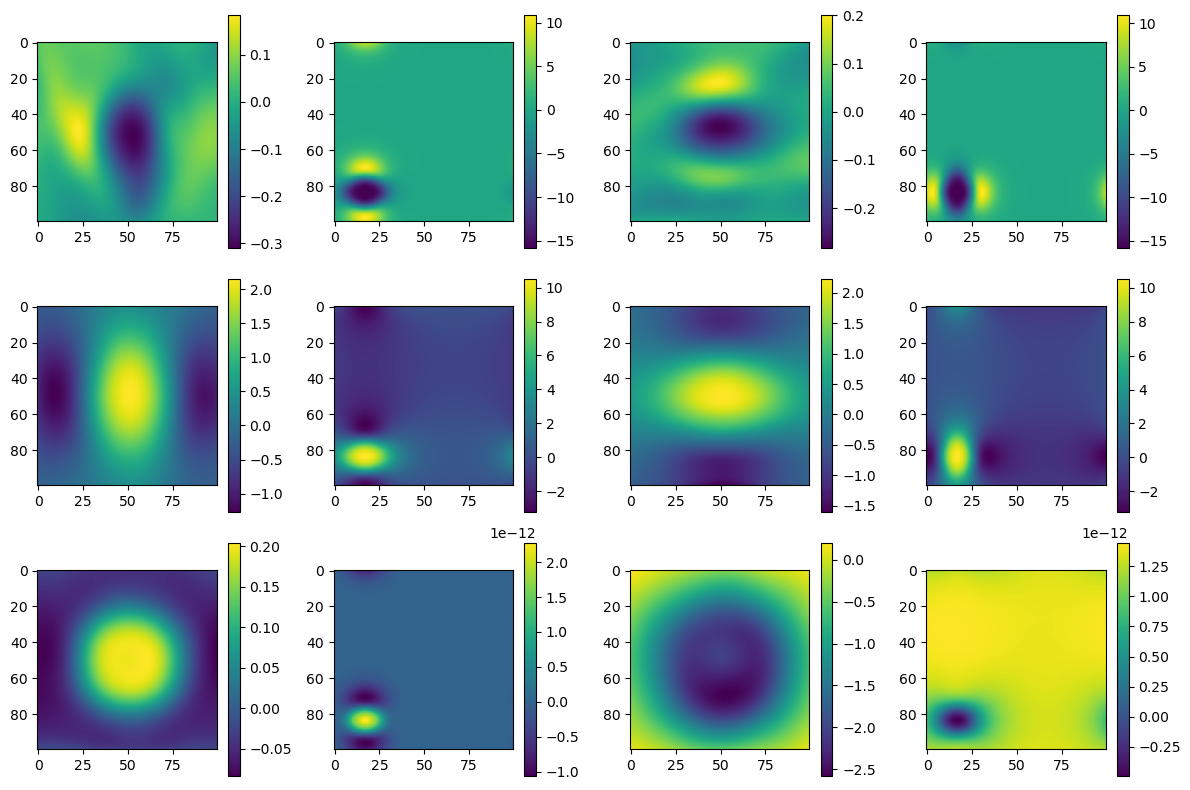

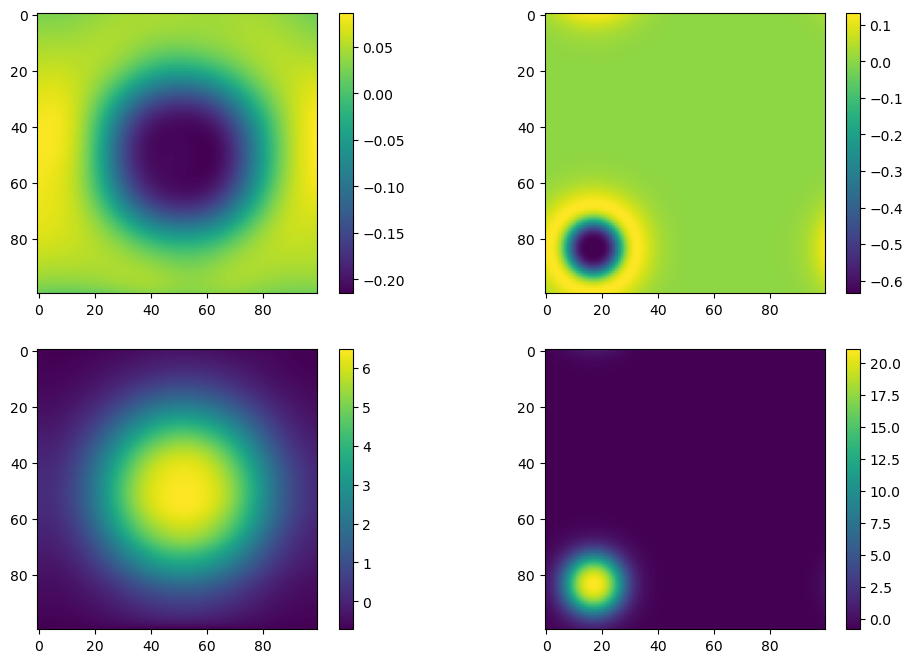

In [131]:
def to(arr):
    return arr.numpy().reshape(pattern.t_star.shape[0], x_range.shape[0], y_range.shape[0])

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(to(u_xx)[-1, ...])
plt.colorbar()
plt.subplot(342)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(343)
plt.imshow(to(u_yy)[-1, ...])
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(to(v_xx)[-1, ...])
plt.colorbar()
plt.subplot(346)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(347)
plt.imshow(to(v_yy)[-1, ...])
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(to(u_t)[-1, ...])
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(to(v_t)[-1, ...])
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(pattern.params["D_u"]*( to(u_xx)[-1, ...] + to(u_yy)[-1, ...]) - to(u_t)[-1, ...])
plt.colorbar()
plt.subplot(222)
plt.imshow(pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(223)
plt.imshow(pattern.params["D_v"]*( to(v_xx)[-1, ...] + to(v_yy)[-1, ...]) - to(v_t)[-1, ...])
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1])
plt.colorbar()

In [101]:
pinn.scales[-1]

<tf.Variable 'Variable:0' shape=(1, 2) dtype=float32, numpy=array([[0.7958191, 0.8619282]], dtype=float32)>

In [105]:
pinn.scales[-1]

<tf.Variable 'Variable:0' shape=(1, 2) dtype=float32, numpy=array([[0.71178246, 0.82297647]], dtype=float32)>

In [96]:
pinn.biases[-1]

<tf.Variable 'Variable:0' shape=(1, 2) dtype=float32, numpy=array([[0., 0.]], dtype=float32)>

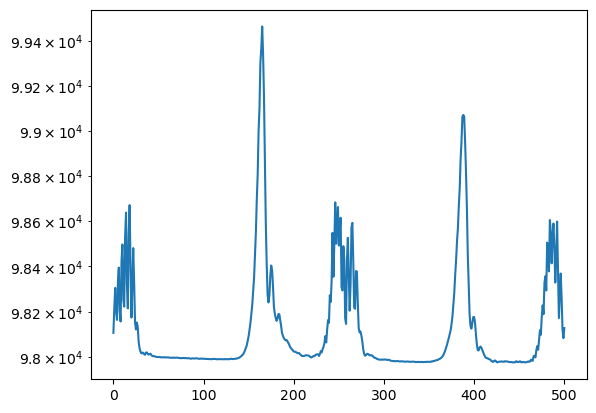

In [92]:
plt.plot(losses[:,1])
plt.yscale('log')

In [81]:
(pattern.params["D_u"]*( to(u_xx)[-1, ...] + to(u_yy)[-1, ...]) - to(u_t)[-1, ...]).shape

(100, 100)